In [154]:
import os 
import pandas as pd 
import re
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

datapath = './Project3CommunityData'
clean_data = 'clean_data'


ping_cols = ['website', 'date', 'time', 'latency_times', 'latency_avg']
#www.cnn.com,05-13-2020,10:00:01,12.8|16.9|8.73|8.61|7.37|7.72|8.63|7.27|15.1|8.29|8.37,9.98090909090909

tr1_cols = ['website', 'date', 'time', 'hop_idx', 'hop_ip', 'latency1', 'latency2', 'latency3', 'latency_avg']
# www.cnn.com,05-13-2020,10:00:01,1,(10.0.0.1),1.558,2.584,3.525,2.5556666666666668

tr2_cols = ['website', 'date', 'time', 'hop_count']
# www.cnn.com,05-16-2020,14:32:47,11

api_cols = ['website', 'call', 'date', 'time', 'latency']
# www.amazon.com,https://www.amazon.com/s?k=networks&ref=nb_sb_noss_2,05-13-2020,14:36:27,41.97399999999999

pchar_agg_cols = ['website', 'date', 'time', 'num_hops']
# en.wikipedia.org,05-13-2020,14:38:49,14

pchar1_cols = ['website', 'date', 'time', 'hop_idx', 'hop_ip', 'hop_rtt', 'hop_pkg_loss']
# en.wikipedia.org,05-13-2020,14:38:49,1,10.0.2.2,0.000000,0

pchar2_cols = ['website', 'date', 'time', 'hop_idx', 'hop_ip', 'hop_bw', 'hop_queing']
# en.wikipedia.org,05-13-2020,14:38:49,0,10.0.2.15,-1,-1

def col_selector(fileType):
    switch = {
        "ping": ping_cols,
        "tr1": tr1_cols,
        "tr2": tr2_cols,
        "api": api_cols,
        "pchar_agg": pchar_agg_cols,
        "pchar1": pchar1_cols,
        "pchar2": pchar2_cols
    }
    
    return switch.get(fileType, "ERROR FILETYPE NOT FOUND: " + fileType)

seqs = ['seq1', 'seq2', 'seq3']

In [160]:
data = {}
teams = os.listdir(datapath)
teams.remove("Team1") # Bad data
teams.remove("Team5") # Bad data
teams.remove("Team8") # Bad data

for team in teams:
    data[team] = {}
    for seq in ['seq1', 'seq2', 'seq3']:
        data[team][seq] = {}
        seq_path = datapath + '/' + team + '/clean_data/' + seq
        for file in os.listdir(seq_path):
            match = re.search('(.*)_(ping|tr1|tr2|pchar1|pchar2|pchar_agg|api)', file)
            website = match.group(1)
            fileType = match.group(2)
            if not website in data[team][seq].keys(): 
                data[team][seq][website] = {}
                
            cols = col_selector(fileType)
            df = pd.read_csv(seq_path + '/' + file, names = cols, header = None)
            data[team][seq][website][fileType] = df

# All data is now read, can be indexed via data[team][seq#][website][fileType]
# team: Team1...Team8
# seq#: seq1, seq2, seq3
# website: e.g. www_cnn_com
# fileType: one of ping|tr1|tr2|pchar1|pchar2|pchar_agg|api

# Seq1: tr1|tr2|ping
# Seq2: tr1|tr2|ping|api
# Seq3: ping|tr1|pchar1|pchar2|pchar_agg

## E2E Route consistency 

Are end-to-end routes and latency consistent within each day, and within the 2 weeks? 


Does the consistency level depend on the measurement location (aka the end host that did the data collection) and the destination site? 


Use graphs/stats to help you present the result, e.g. amount of route changes from day to day (e.g. % of route changes compared to the previous day’s route), latency distribution across 2 weeks. 


Find a way to represent the impact of measurement location and destination site.

#### Note to self: 

For each team: 
- Demonstrate route consistency and route latency for each team for each of the 14 days 
    - Route consistency 
        - Simple analysis: tr1 hop_ip total_count 
            - Plot graph of changes to total # of hops per day (irrespective of what the actual hops were)
                - This will provide a big picture 
        - More advanced analysis: tr1 hop_ip consistency for various days 
            - See if actual routed ip addr changes by day (i.e. keep track of previous day's route, and count the number of hops that changed) 
    - Latency consistency 
        - get mean, std of average latency for each hop `latency_avg`
    
    

#### Preliminary observation 

For each sequence, within each day there are 2 traceroute sessions, and within each session there are 2 `traceroute` calls, leading to effectively 4 traceroute calls per day. These 2 traceroute calls have the same timestamp, which leads to the question of which one to use to analyze route changes within days and across the 2 weeks.

#### Route consistency for same sessions

To begin our analysis, we should first see if E2E route consistency exists within the same session. 

If the E2E route per session is in fact consistent, this would simplify our analysis of multiple day E2E analysis going forward as we can randomly pick one of two traces and still yield meaningful results when analysising route consistency within-day and across 2 weeks.

We achieve this on `tr1` data analysis by first grouping each session together, then see if the 2 `traceroute` results are consistent

In [161]:
# Given 2 sessions, this function returns a route similarity index between 0 and 1
# 1 being the most similar
# 0 being the least similar 
def session_route_similarity_index(s1, s2): 
    s1_route = s1['hop_ip']
    s2_route = s2['hop_ip']
    longest_route_length = max(len(s1_route), len(s2_route))
    n_common_routes = len(list(set(s1_route).intersection(s2_route)))
    index = n_common_routes / longest_route_length
    return index

In [162]:
session_similarities = []
for team in teams: 
    for seq in seqs:
        # Loop over all tr1 datasets for each website 
        websites = list(data[team][seq].keys())
        for website in websites:
            # Analyze tr1 data 
            df = data[team][seq][website]['tr1']
            sessions = df.groupby(['date', 'time'])
            
            # We want to separate out the 2 traceroute instances, which can be differentiated by the repeated hop_idx 
            for session_key, session_df in sessions:
                total_sessions += 1
                tr2_start_pos = -2
                tr1_start_pos = -1
                last_index = -1
                
                for index, row in session_df.iterrows():
                    last_index = index
                    if (tr2_start_pos == -2): #Ignore first entry
                        tr2_start_pos = -1
                        tr1_start_pos = index
                        continue
                        
                    if (row['hop_idx'] == 1):
                        tr2_start_pos = index
                        break
                assert tr2_start_pos >= tr1_start_pos, "Unclean traceroute separation"
                
                # Indexes need be be zero'd in reference to the session_df
                session_tr1_df = session_df.iloc[tr1_start_pos - tr1_start_pos : tr2_start_pos - tr1_start_pos]
                session_tr2_df = session_df.iloc[tr2_start_pos - tr1_start_pos : ]         
                
                session_similarity_index = session_route_similarity_index(session_tr1_df, session_tr2_df)
                session_similarities.append(("{}^{}^{}^{}".format(session_key, website, seq, team), session_similarity_index))
                
                

#### Overall statistics

Total sessions: 2520
Number of sessions with unequal traceroute results 1352
Percentage of sessions with unequal traceroute results 53.65079365079365 %
Average similarity index 0.8427438219654607
Std deviation of similarity index 0.2164384227266379


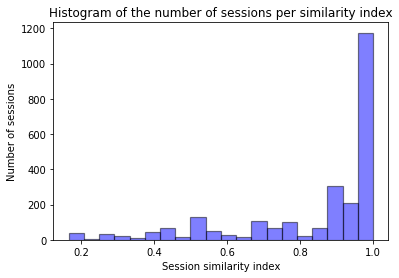

In [163]:
total_sessions = len(session_similarities)
n_unequal_sessions = sum(1 for x in session_similarities if x[1] != 1.0)

print("Total sessions:", total_sessions)
print("Number of sessions with unequal traceroute results", n_unequal_sessions)
print("Percentage of sessions with unequal traceroute results", n_unequal_sessions / total_sessions * 100, "%")
print("Average similarity index", np.mean([x[1] for x in session_similarities]))
print("Std deviation of similarity index", np.std([x[1] for x in session_similarities]))

x = [s[1] for s in session_similarities]
num_bins = 20
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.ylabel("Number of sessions")
plt.xlabel("Session similarity index")
plt.title("Histogram of the number of sessions per similarity index")
plt.show()

From the data bove, we see that the majority of traceroutes within the same session does have the same E2E routing. Even though 51% of the traces are not identical in route, there's still an 85% similarity score on average for our packets. 

Further analysis will require examining session-similarity-index against particular website. A low session-similarity-index could be explained by 2 things: 

1. There are a lot of content distribution servers for a website. I'm guessing that this is probably the case for websites like amazon.com 
2. Network for the team's ISP is unstable  

Additionally, we should also investigate where along the trace does the route start to diverge to differentiate between #1 or #2

#### Latency consistency for same sessions

After looking at route consistency, it would also make sense to quickly look at latency consistency. (TODO)

## Since i'm still waiting for a piazza answer, i'll just pick the first traceroute result for each session to move forward with

### E2E Consistency within each day 

Here we compare the traceroute path between the 2 traceroute sessions for each day.

In [166]:
daily_session_similarities = []
for team in teams: 
    for seq in seqs:
        # Loop over all tr1 datasets for each website 
        websites = list(data[team][seq].keys())
        for website in websites:
            # Analyze tr1 data 
            df = data[team][seq][website]['tr1']
            days = df.groupby(['date'])
            
            # We want to separate out the 2 traceroute instances, which can be differentiated by the repeated hop_idx 
            for day, day_df in days:
                traces = []
                day_group = day_df.groupby(['time'])
                for time, day_time_df in day_group:
                    # We want to only take the first traceroute call instead of second 
                    start_index = -1
                    end_index = -2
                    for index, row in day_time_df.iterrows():
                        if (end_index == -2): #Ignore first entry
                            end_index = -1
                            start_index = index
                            continue

                        if (row['hop_idx'] == 1):
                            end_index = index
                            break
                    traces.append((time, day_time_df.iloc[start_index - start_index:end_index - start_index]))# Zeroing indexes
                
                # Analyze differences in traces[0][1] and traces[1][1]
                daily_session_similarities.append(("{} {} {} {}".format(day, website, seq, team), session_route_similarity_index(traces[0][1], traces[1][1])))
            

#### Overall statistics

Total days entries (total of all teams) 1260
Total number of differing routes 767
Percentage of days with differing routes 60.873015873015866 %
Average daily route similarity index 0.7885663048527072
Standard deviation of route similarity index 0.2526400491315811


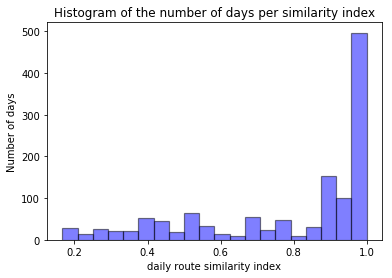

In [175]:
average_daily_session_similarities = np.mean([x[1] for x in daily_session_similarities])
std_daily_session_similarities = np.std([x[1] for x in daily_session_similarities])

total_unequal_entries = sum(1 for x in daily_session_similarities if x[1] != 1.0)
total_entries = len(daily_session_similarities)
print("Total days entries (total of all teams)", total_entries)
print("Total number of differing routes", total_unequal_entries)
print("Percentage of days with differing routes", total_unequal_entries / total_entries * 100, '%')
print("Average daily route similarity index", average_daily_session_similarities)
print("Standard deviation of route similarity index", std_daily_session_similarities)

x = [s[1] for s in daily_session_similarities]
num_bins = 20
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1.2)
plt.ylabel("Number of days")
plt.xlabel("daily route similarity index")
plt.title("Histogram of the number of days per similarity index")
plt.show()

As we can see from the above statistics, 60% of routes do have a differ within the same day. 

The average daily route similarity index is defined as the average fraction across every team of (number of identical hops)/(total number of hops). Keep in mind that an early divergence in pathing would lead to a much lower average daily route similarity index, whereas a later divergence would lead to a higher number, as the route goes through a larger proportional of identical hops. 

An average daily route similarity index of 0.79 indicates that route divergence happens later in the path. However, this number does not reflect hops to different hosts on the same network. I.e. if a website has multiple hosts across the same network, and both sessions goes to different hosts, this number would assume that the routes are completely different. For the purposes of our analysis, we want to treat hops to the same network as an identical path. 

## TODO (Yves): Do longitudinal 2 weeks data analysis  
## TODO (Yves): Do analysis on does route/latency depend on team
## TODO (Yves): Do within-day analysis on latency consistency 
## TODO (Yves): Do longitudinal 2 weeks analysis on latency consistency 
## TODO (Yves): (Extra) Create similarity index based on network instead of entire ip addr